In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from numba import njit, prange

# Параметры системы
l = 32  # длина данных
r = 8   # длина CRC
crc_poly = [1, 0, 0, 0, 0, 0, 1, 1, 1]  # Пример полинома CRC-8 (0x07 в шестнадцатеричном формате)
N = 100000  # количество пакетов
SNR_dBs = np.arange(-5, 11, 2)  # значения SNR в дБ

def compute_crc(data_bits, poly):
    """
    Вычисление CRC для данных
    :param data_bits: список битов данных
    :param poly: порождающий полином (список битов)
    :return: биты CRC
    """
    poly = np.array(poly, dtype=int)
    data = np.array(data_bits, dtype=int)
    len_poly = len(poly)
    len_data = len(data)
    # Сдвигаем данные на (len_poly - 1) бит влево
    shifted_data = np.concatenate([data, np.zeros(len_poly - 1, dtype=int)])
    # Деление полинома
    for i in range(len_data):
        if shifted_data[i] == 1:
            shifted_data[i:i+len_poly] ^= poly
    # Возвращаем остаток
    crc = shifted_data[-len_poly + 1:]
    return crc.tolist()

def bpsk_modulate(bits):
    """
    Модуляция BPSK: 0 -> +1, 1 -> -1
    """
    return np.array([-1 if bit else 1 for bit in bits])

def add_awgn(signal, snr_db):
    """
    Добавление шума к сигналу
    :param signal: модулированный сигнал
    :param snr_db: SNR в дБ
    :return: сигнал с шумом
    """
    snr_linear = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr_linear))
    noise = np.random.normal(0, sigma, len(signal))
    return signal + noise

def bpsk_demodulate(received_signal):
    """
    Демодуляция BPSK: если принятый сигнал >= 0 -> 0, иначе 1
    """
    return [0 if s >= 0 else 1 for s in received_signal]

def check_crc(received_bits, poly):
    """
    Проверка CRC
    :return: синдром (0 - OK, не 0 - ошибка)
    """
    poly = np.array(poly, dtype=int)
    data = np.array(received_bits, dtype=int)
    len_poly = len(poly)
    for i in range(len(data) - len_poly + 1):
        if data[i] == 1:
            data[i:i+len_poly] ^= poly
    syndrome = data[-len_poly + 1:]
    return np.any(syndrome != 0)

# Моделирование
ber_estimates = []
crc_error_estimates = []
theoretical_ber = []
theoretical_crc_error = 1 / (2 ** r)  # Теоретическая вероятность необнаруженной ошибки CRC

for snr_db in SNR_dBs:
    total_bits = 0
    error_bits = 0
    crc_undetected = 0
    
    for _ in range(N):
        # Генерация данных
        m = np.random.randint(0, 2, l).tolist()
        # Вычисление CRC
        crc_bits = compute_crc(m, crc_poly)
        # Кодовое слово
        codeword = m + crc_bits
        # Модуляция
        modulated = bpsk_modulate(codeword)
        # Канал с шумом
        received = add_awgn(modulated, snr_db)
        # Демодуляция
        demod_bits = bpsk_demodulate(received)
        # Проверка CRC
        received_data = demod_bits[:l]
        received_crc = demod_bits[l:]
        # Пересчитываем CRC из полученных данных
        expected_crc = compute_crc(received_data, crc_poly)
        # Синдром
        syndrome = check_crc(demod_bits, crc_poly)
        # Подсчет ошибок
        # Ошибки бит
        bit_errors = sum(r != t for r, t in zip(codeword, demod_bits))
        error_bits += bit_errors
        total_bits += len(codeword)
        # Проверка на необнаруженную ошибку
        if not syndrome:
            if received_data != m:
                crc_undetected += 1
    
    # Оценки
    ber_estimates.append(error_bits / total_bits)
    crc_error_estimates.append(crc_undetected / N)
    # Теоретическая BER
    snr_linear = 10 ** (snr_db / 10)
    theoretical_ber.append(0.5 * erfc(np.sqrt(snr_linear)))

# Построение графиков
plt.figure(figsize=(10, 6))

# График BER
plt.subplot(2, 1, 1)
plt.semilogy(SNR_dBs, ber_estimates, 'bo-', label='Simulated BER')
plt.semilogy(SNR_dBs, theoretical_ber, 'r--', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.legend()

# График ошибок CRC
plt.subplot(2, 1, 2)
plt.semilogy(SNR_dBs, crc_error_estimates, 'go-', label='Simulated CRC Error')
plt.semilogy(SNR_dBs, [theoretical_crc_error]*len(SNR_dBs), 'm--', label='Theoretical CRC Error')
plt.xlabel('SNR (dB)')
plt.ylabel('CRC Undetected Error Rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

C:\Users\Maxim\AppData\Local\Temp\ipykernel_27104\2160146910.py:130: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  A_i = (np.math.comb(n, i)) / (2 ** r)


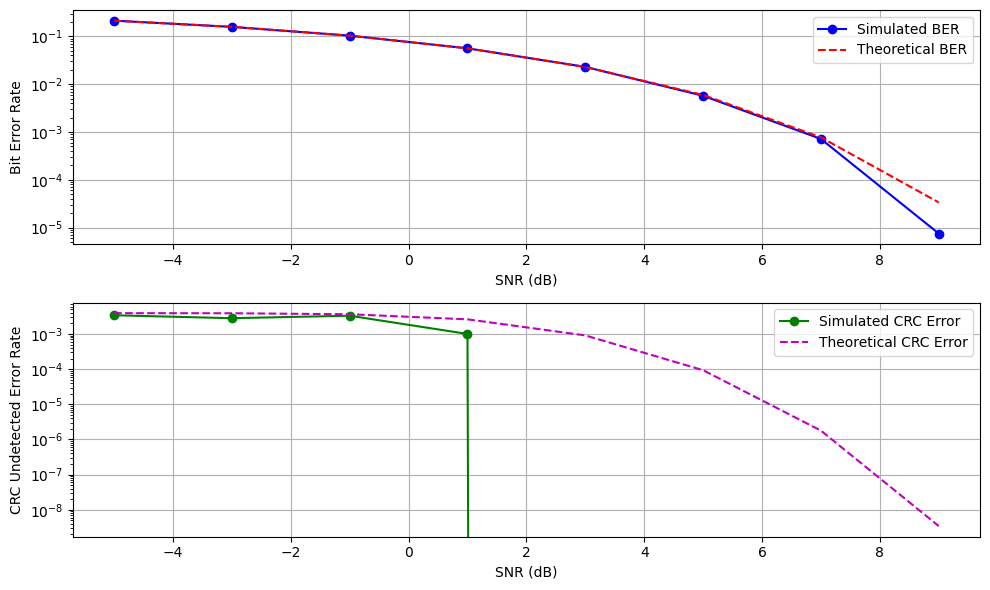

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Параметры системы
l = 32  # длина данных
r = 8   # длина CRC
crc_poly = [1, 0, 0, 0, 0, 0, 1, 1, 1]  # Пример полинома CRC-8 (0x07 в шестнадцатеричном формате)
N = 10000  # количество пакетов
SNR_dBs = np.arange(-5, 11, 2)  # значения SNR в дБ

def compute_crc(data_bits, poly):
    """
    Вычисление CRC для данных
    :param data_bits: список битов данных
    :param poly: порождающий полином (список битов)
    :return: биты CRC
    """
    poly = np.array(poly, dtype=int)
    data = np.array(data_bits, dtype=int)
    len_poly = len(poly)
    len_data = len(data)
    # Сдвигаем данные на (len_poly - 1) бит влево
    shifted_data = np.concatenate([data, np.zeros(len_poly - 1, dtype=int)])
    # Деление полинома
    for i in range(len_data):
        if shifted_data[i] == 1:
            shifted_data[i:i+len_poly] ^= poly
    # Возвращаем остаток
    crc = shifted_data[-len_poly + 1:]
    return crc.tolist()

def bpsk_modulate(bits):
    """
    Модуляция BPSK: 0 -> +1, 1 -> -1
    """
    return np.array([-1 if bit else 1 for bit in bits])

def add_awgn(signal, snr_db):
    """
    Добавление шума к сигналу
    :param signal: модулированный сигнал
    :param snr_db: SNR в дБ
    :return: сигнал с шумом
    """
    snr_linear = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr_linear))
    noise = np.random.normal(0, sigma, len(signal))
    return signal + noise

def bpsk_demodulate(received_signal):
    """
    Демодуляция BPSK: если принятый сигнал >= 0 -> 0, иначе 1
    """
    return [0 if s >= 0 else 1 for s in received_signal]

def check_crc(received_bits, poly):
    poly = np.array(poly, dtype=int)
    data = np.array(received_bits, dtype=int)
    len_poly = len(poly)
    data_copy = data.copy()
    # Обрабатываем все биты, кроме последних len_poly-1
    for i in range(len(data_copy) - len_poly + 1):
        if data_copy[i] == 1:
            data_copy[i:i+len_poly] ^= poly
    syndrome = data_copy[-len_poly + 1:]
    return np.any(syndrome != 0)

# Моделирование
ber_estimates = []
crc_error_estimates = []
theoretical_ber = []
theoretical_crc_error = 1 / (2 ** r)  # Теоретическая вероятность необнаруженной ошибки CRC

for snr_db in SNR_dBs:
    total_bits = 0
    error_bits = 0
    crc_undetected = 0
    
    for _ in range(N):
        # Генерация данных
        m = np.random.randint(0, 2, l).tolist()
        # Вычисление CRC
        crc_bits = compute_crc(m, crc_poly)
        # Кодовое слово
        codeword = m + crc_bits
        # Модуляция
        modulated = bpsk_modulate(codeword)
        # Канал с шумом
        received = add_awgn(modulated, snr_db)
        # Демодуляция
        demod_bits = bpsk_demodulate(received)
        # Проверка CRC
        received_data = demod_bits[:l]
        received_crc = demod_bits[l:]
        # Пересчитываем CRC из полученных данных
        expected_crc = compute_crc(received_data, crc_poly)
        # Синдром
        syndrome = check_crc(demod_bits, crc_poly)
        # Подсчет ошибок
        # Ошибки бит
        bit_errors = sum(r != t for r, t in zip(codeword, demod_bits))
        error_bits += bit_errors
        total_bits += len(codeword)
        # Проверка на необнаруженную ошибку
        if not syndrome:
            if received_data != m:
                crc_undetected += 1
    
    # Оценки
    ber_estimates.append(error_bits / total_bits)
    crc_error_estimates.append(crc_undetected / N)
    # Теоретическая BER
    snr_linear = 10 ** (snr_db / 10)
    theoretical_ber.append(0.5 * erfc(np.sqrt(snr_linear)))

def theoretical_crc_error(snr_db, n, d, r):
    """
    Теоретическая вероятность необнаруженной ошибки CRC.
    :param snr_db: SNR в дБ
    :param n: длина кодового слова (данные + CRC)
    :param d: минимальное расстояние кода
    :param r: длина CRC
    :return: P_e
    """
    p = 0.5 * erfc(np.sqrt(10 ** (snr_db / 10)))  # BER для BPSK
    Pe = 0
    for i in range(d, n + 1):
        # Приближение: A_i ≈ C(n, i) / 2^r
        A_i = (np.math.comb(n, i)) / (2 ** r)
        Pe += A_i * (p ** i) * ((1 - p) ** (n - i))
    return Pe

# Построение графиков
plt.figure(figsize=(10, 6))

# График BER
plt.subplot(2, 1, 1)
plt.semilogy(SNR_dBs, ber_estimates, 'bo-', label='Simulated BER')
plt.semilogy(SNR_dBs, theoretical_ber, 'r--', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.legend()

# График ошибок CRC
plt.subplot(2, 1, 2)

# На вычисление для каждого SNR:
theoretical_crc = [theoretical_crc_error(snr, n=l+r, d=2, r=r) for snr in SNR_dBs]

# Затем в построении графика:
plt.semilogy(SNR_dBs, crc_error_estimates, 'go-', label='Simulated CRC Error')
plt.semilogy(SNR_dBs, theoretical_crc, 'm--', label='Theoretical CRC Error')
plt.xlabel('SNR (dB)')
plt.ylabel('CRC Undetected Error Rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 100000/100000 [00:09<00:00, 10090.02it/s]


0.01499



100%|██████████| 100000/100000 [00:09<00:00, 10090.61it/s]


0.01508



100%|██████████| 100000/100000 [00:09<00:00, 10229.27it/s]


0.01191



100%|██████████| 100000/100000 [00:09<00:00, 10171.30it/s]


0.00605



100%|██████████| 100000/100000 [00:09<00:00, 10221.13it/s]


0.0016



100%|██████████| 100000/100000 [00:09<00:00, 10169.43it/s]


9e-05



100%|██████████| 100000/100000 [00:09<00:00, 10439.67it/s]


1e-05



100%|██████████| 100000/100000 [00:09<00:00, 10396.42it/s]
C:\Users\Maxim\AppData\Local\Temp\ipykernel_27104\3374323296.py:138: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  A_i = (np.math.comb(n, i)) / (2 ** r)


0.0



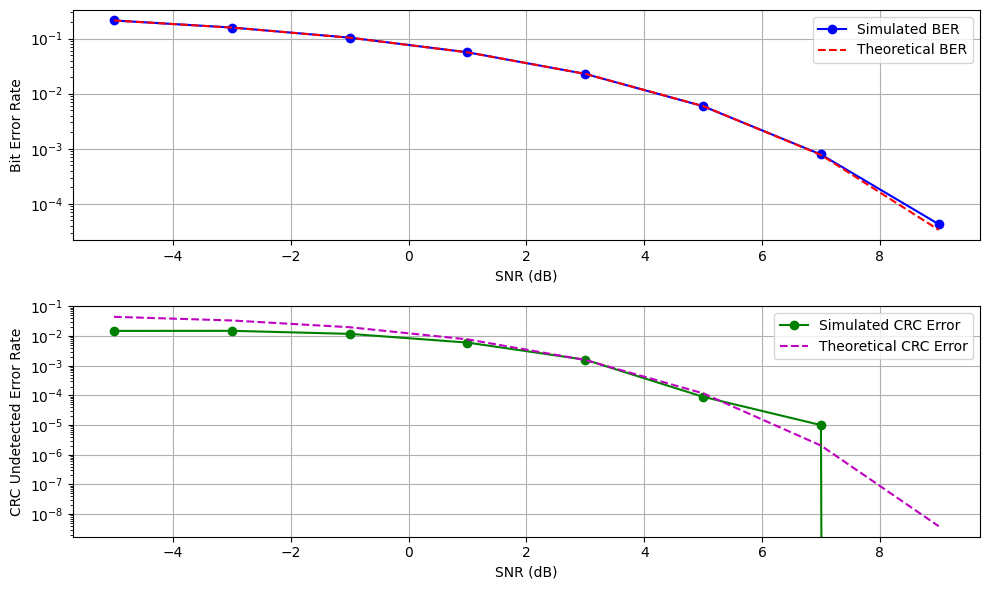

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm import tqdm

# r = 8   # длина CRC
r = 4
# l = 32  # длина данных
l = 7
# crc_poly = [1, 0, 0, 0, 0, 0, 1, 1, 1]
crc_poly = [1, 1, 1, 0, 1, 0, 0, 0, 0]
N = 100000  # количество пакетов
SNR_dBs = np.arange(-5, 11, 2)  # значения SNR в дБ


def compute_crc(data_bits, poly):
    """
    Вычисление CRC для данных
    :param data_bits: список битов данных
    :param poly: порождающий полином (список битов)
    :return: биты CRC
    """
    poly = np.array(poly, dtype=int)
    data = np.array(data_bits, dtype=int)
    len_poly = len(poly)
    len_data = len(data)
    # Сдвигаем данные на (len_poly - 1) бит влево
    shifted_data = np.concatenate([data, np.zeros(len_poly - 1, dtype=int)])
    # Деление полинома
    for i in range(len_data):
        if shifted_data[i] == 1:
            shifted_data[i:i+len_poly] ^= poly
    # Возвращаем остаток
    crc = shifted_data[-len_poly + 1:]
    return crc.tolist()

def bpsk_modulate(bits):
    """
    Модуляция BPSK: 0 -> +1, 1 -> -1
    """
    return np.array([-1 if bit else 1 for bit in bits])

def add_awgn(signal, snr_db):
    """
    Добавление шума к сигналу
    :param signal: модулированный сигнал
    :param snr_db: SNR в дБ
    :return: сигнал с шумом
    """
    snr_linear = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr_linear))
    noise = np.random.normal(0, sigma, len(signal))
    return signal + noise

def bpsk_demodulate(received_signal):
    """
    Демодуляция BPSK: если принятый сигнал >= 0 -> 0, иначе 1
    """
    return [0 if s >= 0 else 1 for s in received_signal]

def check_crc(received_bits, poly):
    poly = np.array(poly, dtype=int)
    data = np.array(received_bits, dtype=int)
    len_poly = len(poly)
    data_copy = data.copy()
    # Обрабатываем все биты, кроме последних len_poly-1
    for i in range(len(data_copy) - len_poly + 1):
        if data_copy[i] == 1:
            data_copy[i:i+len_poly] ^= poly
    syndrome = data_copy[-len_poly + 1:]
    return np.any(syndrome != 0)

# Моделирование
ber_estimates = []
crc_error_estimates = []
theoretical_ber = []
theoretical_crc_error = 1 / (2 ** r)  # Теоретическая вероятность необнаруженной ошибки CRC


for snr_db in SNR_dBs:
    total_bits = 0
    error_bits = 0
    crc_undetected = 0
    
    for _ in tqdm(range(N)):
        # Генерация данных
        m = np.random.randint(0, 2, l).tolist()
        # Вычисление CRC
        crc_bits = compute_crc(m, crc_poly)
        # Кодовое слово
        codeword = m + crc_bits
        # Модуляция
        modulated = bpsk_modulate(codeword)
        # Канал с шумом
        received = add_awgn(modulated, snr_db)
        # Демодуляция
        demod_bits = bpsk_demodulate(received)
        # Проверка CRC
        received_data = demod_bits[:l]
        received_crc = demod_bits[l:]
        # Пересчитываем CRC из полученных данных
        expected_crc = compute_crc(received_data, crc_poly)
        # Синдром
        syndrome = check_crc(demod_bits, crc_poly)
        # Подсчет ошибок
        # Ошибки бит
        bit_errors = sum(r != t for r, t in zip(codeword, demod_bits))
        error_bits += bit_errors
        total_bits += len(codeword)
        # Проверка на необнаруженную ошибку
        if not syndrome:
            if received_data != m:
            # if codeword != demod_bits:
                crc_undetected += 1 
    
    # Оценки
    ber_estimates.append(error_bits / total_bits)
    crc_error_estimates.append(crc_undetected / N)
    print(crc_undetected / N)
    print()
    # Теоретическая BER
    snr_linear = 10 ** (snr_db / 10)
    theoretical_ber.append(0.5 * erfc(np.sqrt(snr_linear)))

def theoretical_crc_error(snr_db, n, d, r):
    """
    Теоретическая вероятность необнаруженной ошибки CRC.
    :param snr_db: SNR в дБ
    :param n: длина кодового слова (данные + CRC)
    :param d: минимальное расстояние кода
    :param r: длина CRC
    :return: P_e
    """
    p = 0.5 * erfc(np.sqrt(10 ** (snr_db / 10)))  # BER для BPSK
    Pe = 0
    for i in range(d, n + 1):
        # Приближение: A_i ≈ C(n, i) / 2^r
        A_i = (np.math.comb(n, i)) / (2 ** r)
        Pe += A_i * (p ** i) * ((1 - p) ** (n - i))
    return Pe

# Построение графиков
plt.figure(figsize=(10, 6))

# График BER
plt.subplot(2, 1, 1)
plt.semilogy(SNR_dBs, ber_estimates, 'bo-', label='Simulated BER')
plt.semilogy(SNR_dBs, theoretical_ber, 'r--', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.legend()

# График ошибок CRC
plt.subplot(2, 1, 2)

# На вычисление для каждого SNR:
theoretical_crc = [theoretical_crc_error(snr, n=l+r, d=2, r=r) for snr in SNR_dBs]

# Затем в построении графика:
plt.semilogy(SNR_dBs, crc_error_estimates, 'go-', label='Simulated CRC Error')
plt.semilogy(SNR_dBs, theoretical_crc, 'm--', label='Theoretical CRC Error')
plt.xlabel('SNR (dB)')
plt.ylabel('CRC Undetected Error Rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\Maxim\AppData\Local\Temp\ipykernel_2808\1876134308.py:84: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  A_i = (np.math.comb(n, i)) / (2 ** r)


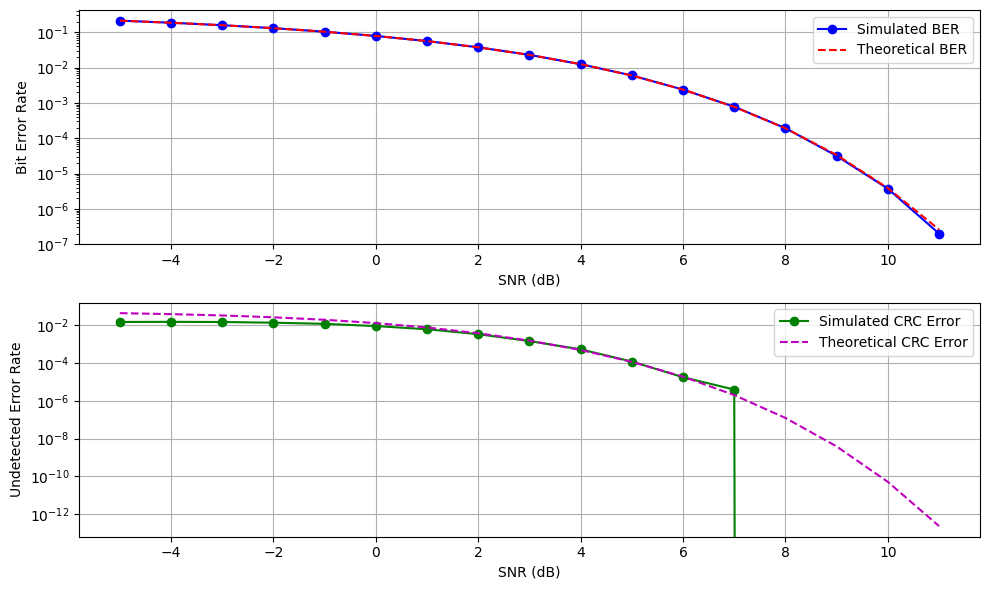

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
# from tqdm import tqdm
import numba as nb

# Параметры
r = 4
l = 7
crc_poly = np.array([1, 1, 1, 0, 1, 0, 0, 0, 0], dtype=np.int8)
N = 1000000
SNR_dBs = np.arange(-5, 12, 1)
# SNR_dBs = np.arange(0, 16, 2)

@nb.njit(nb.int8[:](nb.int8[:], nb.int8[:]))
def compute_crc(data_bits, poly):
    len_poly = len(poly)
    len_data = len(data_bits)
    shifted_data = np.zeros(len_data + len_poly - 1, dtype=np.int8)
    shifted_data[:len_data] = data_bits
    for i in range(len_data):
        if shifted_data[i] == 1:
            shifted_data[i:i+len_poly] ^= poly
    return shifted_data[-len_poly + 1:]

@nb.njit(nb.float64[:](nb.int8[:]))
def bpsk_modulate(bits):
    return 1.0 - 2.0 * bits.astype(np.float64)

@nb.njit(nb.float64[:](nb.float64[:], nb.float64))
def add_awgn(signal, snr_db):
    snr_linear = 10.0 ** (snr_db / 10.0)
    sigma = np.sqrt(1.0 / (2.0 * snr_linear))
    noise = np.random.normal(0, sigma, len(signal)).astype(np.float64)
    return signal + noise

@nb.njit(nb.int8[:](nb.float64[:]))
def bpsk_demodulate(received_signal):
    return (received_signal < 0).astype(np.int8)

@nb.njit(nb.boolean(nb.int8[:], nb.int8[:]))
def check_crc(received_bits, poly):
    len_poly = len(poly)
    data_copy = received_bits.copy()
    for i in range(len(data_copy) - len_poly + 1):
        if data_copy[i] == 1:
            data_copy[i:i+len_poly] ^= poly
    return np.any(data_copy[-len_poly + 1:] != 0)

@nb.njit(parallel=True)
def simulate(N, l, r, crc_poly, SNR_dBs):
    ber_estimates = np.zeros(len(SNR_dBs))
    crc_error_estimates = np.zeros(len(SNR_dBs))
    
    for snr_idx in nb.prange(len(SNR_dBs)):
        snr_db = SNR_dBs[snr_idx]
        total_bits = 0
        error_bits = 0
        crc_undetected = 0
        
        for _ in range(N):
            m = np.random.randint(0, 2, l).astype(np.int8)
            crc = compute_crc(m, crc_poly)
            codeword = np.concatenate((m, crc))
            modulated = bpsk_modulate(codeword)
            received = add_awgn(modulated, snr_db)
            demod_bits = bpsk_demodulate(received)
            syndrome = check_crc(demod_bits, crc_poly)
            bit_errors = np.sum(codeword != demod_bits)
            error_bits += bit_errors
            total_bits += len(codeword)
            if not syndrome and not np.array_equal(m, demod_bits[:l]):
                crc_undetected += 1
                
        ber_estimates[snr_idx] = error_bits / total_bits
        crc_error_estimates[snr_idx] = crc_undetected / N
    
    return ber_estimates, crc_error_estimates

def theoretical_crc_error(snr_db, n, d, r):
    p = 0.5 * erfc(np.sqrt(10 ** (snr_db / 10)))
    Pe = 0
    for i in range(d, n + 1):
        A_i = (np.math.comb(n, i)) / (2 ** r)
        Pe += A_i * (p ** i) * ((1 - p) ** (n - i))
    return Pe

ber_estimates, crc_error_estimates = simulate(N, l, r, crc_poly, SNR_dBs)

theoretical_ber = [0.5 * erfc(np.sqrt(10 ** (snr_db / 10))) for snr_db in SNR_dBs]
theoretical_crc = [theoretical_crc_error(snr, n=l+r, d=2, r=r) for snr in SNR_dBs]


plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.semilogy(SNR_dBs, ber_estimates, 'bo-', label='Simulated BER')
plt.semilogy(SNR_dBs, theoretical_ber, 'r--', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogy(SNR_dBs, crc_error_estimates, 'go-', label='Simulated CRC Error')
plt.semilogy(SNR_dBs, theoretical_crc, 'm--', label='Theoretical CRC Error')
plt.xlabel('SNR (dB)')
plt.ylabel('Undetected Error Rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()